In [2]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [536]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [537]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

In [538]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [539]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [540]:
spatial_data.shape

(13, 100, 35040)

In [541]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

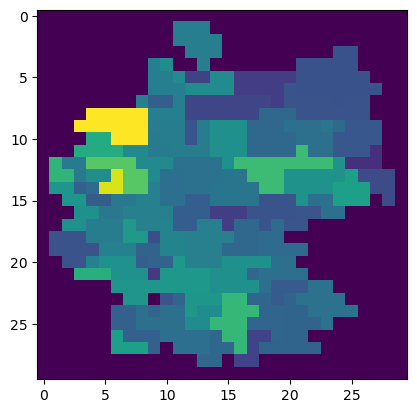

In [542]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [543]:
image_all.shape

(35040, 30, 30, 13)

In [544]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [545]:
output = df_powerprice["Spot"].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output.shape

(35040, 1)

In [546]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [547]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036, 1)


In [548]:
# Reshape the input array to a 2D array
input_2d = X.reshape(-1, X.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X = input_scaled.reshape(X.shape)

print("Scaled X shape:", X_scaled.shape)

Scaled X shape: (35036, 4, 30, 30, 13)


In [549]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22422, 4, 30, 30, 13)
y_train shape: (22422, 1)
X_val shape: (5606, 4, 30, 30, 13)
y_val shape: (5606, 1)
X_test shape: (7008, 4, 30, 30, 13)
y_test shape: (7008, 1)


In [550]:
time_steps = 4
width = 30
height = 30
channel = 13

# Define the input layer
input_layer = Input(shape=(time_steps, width, height, channel))

# Define the convolutional layers
cnn1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
cnn2 = MaxPooling2D(pool_size=(2, 2))
cnn3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
cnn4 = MaxPooling2D(pool_size=(2, 2))

# Apply TimeDistributed to the convolutional layers
td_cnn1 = TimeDistributed(cnn1)(input_layer)
td_cnn2 = TimeDistributed(cnn2)(td_cnn1)
td_cnn3 = TimeDistributed(cnn3)(td_cnn2)
td_cnn4 = TimeDistributed(cnn4)(td_cnn3)

# Reshape the output of the convolutional layers
reshaped = Reshape((-1, 6*6*32))(td_cnn4)

# Apply TimeDistributed Dense layer
td_fcnn = TimeDistributed(Dense(10, activation='relu', name='output'))(reshaped)

# Apply LSTM layer
lstm_output = LSTM(1, name='lstm1_1')(td_fcnn)

# Create the model
model = Model(inputs=input_layer, outputs=lstm_output)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 30, 30, 13)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 28, 28, 16)    1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 14, 14, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 4, 12, 12, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 6, 6, 32)      0         
 tributed)                                                   

In [551]:
# Compile the model with an appropriate optimizer and loss function

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [552]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [553]:
cp = ModelCheckpoint(filepath="training/cnn-lstm/", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [ ]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
698/701 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0470
Epoch 1: val_loss improved from inf to 0.00041, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 24s 31ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 4.0611e-04 - val_root_mean_squared_error: 0.0202
Epoch 2/1000
696/701 [============================>.] - ETA: 0s - loss: 3.4371e-04 - root_mean_squared_error: 0.0185
Epoch 2: val_loss improved from 0.00041 to 0.00036, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 17s 24ms/step - loss: 3.4358e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.6083e-04 - val_root_mean_squared_error: 0.0190
Epoch 3/1000
697/701 [============================>.] - ETA: 0s - loss: 2.9244e-04 - root_mean_squared_error: 0.0171
Epoch 3: val_loss improved from 0.00036 to 0.00030, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 22ms/step - loss: 2.9205e-04 - root_mean_squared_error: 0.0171 - val_loss: 2.9775e-04 - val_root_mean_squared_error: 0.0173
Epoch 4/1000
699/701 [============================>.] - ETA: 0s - loss: 2.7135e-04 - root_mean_squared_error: 0.0165
Epoch 4: val_loss improved from 0.00030 to 0.00028, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 2.7102e-04 - root_mean_squared_error: 0.0165 - val_loss: 2.7590e-04 - val_root_mean_squared_error: 0.0166
Epoch 5/1000
701/701 [==============================] - ETA: 0s - loss: 2.5392e-04 - root_mean_squared_error: 0.0159
Epoch 5: val_loss improved from 0.00028 to 0.00027, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 22ms/step - loss: 2.5392e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.7490e-04 - val_root_mean_squared_error: 0.0166
Epoch 6/1000
699/701 [============================>.] - ETA: 0s - loss: 2.4619e-04 - root_mean_squared_error: 0.0157
Epoch 6: val_loss improved from 0.00027 to 0.00027, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 2.4598e-04 - root_mean_squared_error: 0.0157 - val_loss: 2.6556e-04 - val_root_mean_squared_error: 0.0163
Epoch 7/1000
698/701 [============================>.] - ETA: 0s - loss: 2.3512e-04 - root_mean_squared_error: 0.0153
Epoch 7: val_loss improved from 0.00027 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.3494e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.4494e-04 - val_root_mean_squared_error: 0.0157
Epoch 8/1000
697/701 [============================>.] - ETA: 0s - loss: 2.3376e-04 - root_mean_squared_error: 0.0153
Epoch 8: val_loss improved from 0.00024 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.3335e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.4170e-04 - val_root_mean_squared_error: 0.0155
Epoch 9/1000
698/701 [============================>.] - ETA: 0s - loss: 2.2726e-04 - root_mean_squared_error: 0.0151
Epoch 9: val_loss improved from 0.00024 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 21ms/step - loss: 2.2714e-04 - root_mean_squared_error: 0.0151 - val_loss: 2.3501e-04 - val_root_mean_squared_error: 0.0153
Epoch 10/1000
697/701 [============================>.] - ETA: 0s - loss: 2.2312e-04 - root_mean_squared_error: 0.0149
Epoch 10: val_loss did not improve from 0.00024
701/701 [==============================] - 8s 12ms/step - loss: 2.2268e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.5460e-04 - val_root_mean_squared_error: 0.0160
Epoch 11/1000
701/701 [==============================] - ETA: 0s - loss: 2.2068e-04 - root_mean_squared_error: 0.0149
Epoch 11: val_loss improved from 0.00024 to 0.00023, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 21ms/step - loss: 2.2068e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.2726e-04 - val_root_mean_squared_error: 0.0151
Epoch 12/1000
701/701 [==============================] - ETA: 0s - loss: 2.1353e-04 - root_mean_squared_error: 0.0146
Epoch 12: val_loss did not improve from 0.00023
701/701 [==============================] - 9s 13ms/step - loss: 2.1353e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.4374e-04 - val_root_mean_squared_error: 0.0156
Epoch 13/1000
700/701 [============================>.] - ETA: 0s - loss: 2.0587e-04 - root_mean_squared_error: 0.0143
Epoch 13: val_loss improved from 0.00023 to 0.00023, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 21ms/step - loss: 2.0955e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.2710e-04 - val_root_mean_squared_error: 0.0151
Epoch 14/1000
695/701 [============================>.] - ETA: 0s - loss: 2.0930e-04 - root_mean_squared_error: 0.0145
Epoch 14: val_loss improved from 0.00023 to 0.00022, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.0849e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.2256e-04 - val_root_mean_squared_error: 0.0149
Epoch 15/1000
696/701 [============================>.] - ETA: 0s - loss: 2.0507e-04 - root_mean_squared_error: 0.0143
Epoch 15: val_loss improved from 0.00022 to 0.00021, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.0530e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.1437e-04 - val_root_mean_squared_error: 0.0146
Epoch 16/1000
698/701 [============================>.] - ETA: 0s - loss: 2.0159e-04 - root_mean_squared_error: 0.0142
Epoch 16: val_loss improved from 0.00021 to 0.00021, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 17s 24ms/step - loss: 2.0111e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.1224e-04 - val_root_mean_squared_error: 0.0146
Epoch 17/1000
697/701 [============================>.] - ETA: 0s - loss: 1.9910e-04 - root_mean_squared_error: 0.0141
Epoch 17: val_loss did not improve from 0.00021
701/701 [==============================] - 9s 12ms/step - loss: 1.9879e-04 - root_mean_squared_error: 0.0141 - val_loss: 2.1975e-04 - val_root_mean_squared_error: 0.0148
Epoch 18/1000
698/701 [============================>.] - ETA: 0s - loss: 1.9572e-04 - root_mean_squared_error: 0.0140
Epoch 18: val_loss improved from 0.00021 to 0.00020, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.9556e-04 - root_mean_squared_error: 0.0140 - val_loss: 2.0300e-04 - val_root_mean_squared_error: 0.0142
Epoch 19/1000
700/701 [============================>.] - ETA: 0s - loss: 1.9483e-04 - root_mean_squared_error: 0.0140
Epoch 19: val_loss did not improve from 0.00020
701/701 [==============================] - 8s 12ms/step - loss: 1.9491e-04 - root_mean_squared_error: 0.0140 - val_loss: 2.1311e-04 - val_root_mean_squared_error: 0.0146
Epoch 20/1000
699/701 [============================>.] - ETA: 0s - loss: 1.9263e-04 - root_mean_squared_error: 0.0139
Epoch 20: val_loss did not improve from 0.00020
701/701 [==============================] - 9s 13ms/step - loss: 1.9240e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.1215e-04 - val_root_mean_squared_error: 0.0146
Epoch 21/1000
698/701 [============================>.] - ETA: 0s - loss: 1.8787e-04 - root_mean_squared_error: 0.0137
Epoch 21: val_loss improved from 0.0002

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 16s 22ms/step - loss: 1.8759e-04 - root_mean_squared_error: 0.0137 - val_loss: 1.9756e-04 - val_root_mean_squared_error: 0.0141
Epoch 22/1000
696/701 [============================>.] - ETA: 0s - loss: 1.8945e-04 - root_mean_squared_error: 0.0138
Epoch 22: val_loss improved from 0.00020 to 0.00020, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.8898e-04 - root_mean_squared_error: 0.0137 - val_loss: 1.9549e-04 - val_root_mean_squared_error: 0.0140
Epoch 23/1000
701/701 [==============================] - ETA: 0s - loss: 1.8577e-04 - root_mean_squared_error: 0.0136
Epoch 23: val_loss did not improve from 0.00020
701/701 [==============================] - 8s 11ms/step - loss: 1.8577e-04 - root_mean_squared_error: 0.0136 - val_loss: 1.9737e-04 - val_root_mean_squared_error: 0.0140
Epoch 24/1000
697/701 [============================>.] - ETA: 0s - loss: 1.8383e-04 - root_mean_squared_error: 0.0136
Epoch 24: val_loss improved from 0.00020 to 0.00019, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 21ms/step - loss: 1.8353e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.9010e-04 - val_root_mean_squared_error: 0.0138
Epoch 25/1000
699/701 [============================>.] - ETA: 0s - loss: 1.8080e-04 - root_mean_squared_error: 0.0134
Epoch 25: val_loss improved from 0.00019 to 0.00019, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.8088e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.8813e-04 - val_root_mean_squared_error: 0.0137
Epoch 26/1000
701/701 [==============================] - ETA: 0s - loss: 1.7818e-04 - root_mean_squared_error: 0.0133
Epoch 26: val_loss did not improve from 0.00019
701/701 [==============================] - 9s 13ms/step - loss: 1.7818e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.8949e-04 - val_root_mean_squared_error: 0.0138
Epoch 27/1000
695/701 [============================>.] - ETA: 0s - loss: 1.7467e-04 - root_mean_squared_error: 0.0132
Epoch 27: val_loss did not improve from 0.00019
701/701 [==============================] - 8s 12ms/step - loss: 1.7417e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.9118e-04 - val_root_mean_squared_error: 0.0138
Epoch 28/1000
700/701 [============================>.] - ETA: 0s - loss: 1.7396e-04 - root_mean_squared_error: 0.0132
Epoch 28: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.7037e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.8038e-04 - val_root_mean_squared_error: 0.0134
Epoch 31/1000
700/701 [============================>.] - ETA: 0s - loss: 1.6877e-04 - root_mean_squared_error: 0.0130
Epoch 31: val_loss did not improve from 0.00018
701/701 [==============================] - 8s 12ms/step - loss: 1.6867e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.9610e-04 - val_root_mean_squared_error: 0.0140
Epoch 32/1000
700/701 [============================>.] - ETA: 0s - loss: 1.6786e-04 - root_mean_squared_error: 0.0130
Epoch 32: val_loss improved from 0.00018 to 0.00018, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.6776e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.7864e-04 - val_root_mean_squared_error: 0.0134
Epoch 33/1000
696/701 [============================>.] - ETA: 0s - loss: 1.6503e-04 - root_mean_squared_error: 0.0128
Epoch 33: val_loss improved from 0.00018 to 0.00017, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.6482e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.7301e-04 - val_root_mean_squared_error: 0.0132
Epoch 34/1000
697/701 [============================>.] - ETA: 0s - loss: 1.6445e-04 - root_mean_squared_error: 0.0128
Epoch 34: val_loss did not improve from 0.00017
701/701 [==============================] - 8s 11ms/step - loss: 1.6422e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.9106e-04 - val_root_mean_squared_error: 0.0138
Epoch 35/1000
697/701 [============================>.] - ETA: 0s - loss: 1.6306e-04 - root_mean_squared_error: 0.0128
Epoch 35: val_loss did not improve from 0.00017
701/701 [==============================] - 8s 11ms/step - loss: 1.6298e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.0275e-04 - val_root_mean_squared_error: 0.0142
Epoch 36/1000
697/701 [============================>.] - ETA: 0s - loss: 1.6301e-04 - root_mean_squared_error: 0.0128
Epoch 36: val_loss improved from 0.0001

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.6271e-04 - root_mean_squared_error: 0.0128 - val_loss: 1.6402e-04 - val_root_mean_squared_error: 0.0128
Epoch 37/1000
699/701 [============================>.] - ETA: 0s - loss: 1.6092e-04 - root_mean_squared_error: 0.0127
Epoch 37: val_loss did not improve from 0.00016
701/701 [==============================] - 9s 12ms/step - loss: 1.6087e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.6855e-04 - val_root_mean_squared_error: 0.0130
Epoch 38/1000
696/701 [============================>.] - ETA: 0s - loss: 1.6031e-04 - root_mean_squared_error: 0.0127
Epoch 38: val_loss did not improve from 0.00016
701/701 [==============================] - 9s 12ms/step - loss: 1.6002e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.6554e-04 - val_root_mean_squared_error: 0.0129
Epoch 39/1000
699/701 [============================>.] - ETA: 0s - loss: 1.5881e-04 - root_mean_squared_error: 0.0126
Epoch 39: val_loss improved from 0.0001

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 16s 23ms/step - loss: 1.5871e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.6324e-04 - val_root_mean_squared_error: 0.0128
Epoch 40/1000
701/701 [==============================] - ETA: 0s - loss: 1.5844e-04 - root_mean_squared_error: 0.0126
Epoch 40: val_loss did not improve from 0.00016
701/701 [==============================] - 9s 13ms/step - loss: 1.5844e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.8358e-04 - val_root_mean_squared_error: 0.0135
Epoch 41/1000
695/701 [============================>.] - ETA: 0s - loss: 1.5540e-04 - root_mean_squared_error: 0.0125
Epoch 41: val_loss did not improve from 0.00016
701/701 [==============================] - 8s 11ms/step - loss: 1.5484e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6477e-04 - val_root_mean_squared_error: 0.0128
Epoch 42/1000
701/701 [==============================] - ETA: 0s - loss: 1.5376e-04 - root_mean_squared_error: 0.0124
Epoch 42: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 21ms/step - loss: 1.5291e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.5724e-04 - val_root_mean_squared_error: 0.0125
Epoch 44/1000
699/701 [============================>.] - ETA: 0s - loss: 1.5561e-04 - root_mean_squared_error: 0.0125
Epoch 44: val_loss did not improve from 0.00016
701/701 [==============================] - 9s 13ms/step - loss: 1.5555e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6589e-04 - val_root_mean_squared_error: 0.0129
Epoch 45/1000
699/701 [============================>.] - ETA: 0s - loss: 1.5030e-04 - root_mean_squared_error: 0.0123
Epoch 45: val_loss did not improve from 0.00016
701/701 [==============================] - 8s 12ms/step - loss: 1.5017e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.5781e-04 - val_root_mean_squared_error: 0.0126
Epoch 46/1000
700/701 [============================>.] - ETA: 0s - loss: 1.5001e-04 - root_mean_squared_error: 0.0122
Epoch 46: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.4761e-04 - root_mean_squared_error: 0.0121 - val_loss: 1.5407e-04 - val_root_mean_squared_error: 0.0124
Epoch 50/1000
700/701 [============================>.] - ETA: 0s - loss: 1.4566e-04 - root_mean_squared_error: 0.0121
Epoch 50: val_loss improved from 0.00015 to 0.00015, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.4575e-04 - root_mean_squared_error: 0.0121 - val_loss: 1.5001e-04 - val_root_mean_squared_error: 0.0122
Epoch 51/1000
697/701 [============================>.] - ETA: 0s - loss: 1.4442e-04 - root_mean_squared_error: 0.0120
Epoch 51: val_loss did not improve from 0.00015
701/701 [==============================] - 9s 12ms/step - loss: 1.4454e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.6204e-04 - val_root_mean_squared_error: 0.0127
Epoch 52/1000
699/701 [============================>.] - ETA: 0s - loss: 1.4575e-04 - root_mean_squared_error: 0.0121
Epoch 52: val_loss improved from 0.00015 to 0.00015, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.4589e-04 - root_mean_squared_error: 0.0121 - val_loss: 1.4742e-04 - val_root_mean_squared_error: 0.0121
Epoch 53/1000
697/701 [============================>.] - ETA: 0s - loss: 1.4281e-04 - root_mean_squared_error: 0.0120
Epoch 53: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 11ms/step - loss: 1.4251e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.5140e-04 - val_root_mean_squared_error: 0.0123
Epoch 54/1000
695/701 [============================>.] - ETA: 0s - loss: 1.4304e-04 - root_mean_squared_error: 0.0120
Epoch 54: val_loss did not improve from 0.00015
701/701 [==============================] - 8s 11ms/step - loss: 1.4273e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.6018e-04 - val_root_mean_squared_error: 0.0127
Epoch 55/1000
700/701 [============================>.] - ETA: 0s - loss: 1.4174e-04 - root_mean_squared_error: 0.0119
Epoch 55: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.3645e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.4457e-04 - val_root_mean_squared_error: 0.0120
Epoch 62/1000
695/701 [============================>.] - ETA: 0s - loss: 1.3639e-04 - root_mean_squared_error: 0.0117
Epoch 62: val_loss improved from 0.00014 to 0.00014, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.3591e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.4278e-04 - val_root_mean_squared_error: 0.0119
Epoch 63/1000
697/701 [============================>.] - ETA: 0s - loss: 1.3500e-04 - root_mean_squared_error: 0.0116
Epoch 63: val_loss did not improve from 0.00014
701/701 [==============================] - 8s 12ms/step - loss: 1.3491e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.5092e-04 - val_root_mean_squared_error: 0.0123
Epoch 64/1000
700/701 [============================>.] - ETA: 0s - loss: 1.3565e-04 - root_mean_squared_error: 0.0116
Epoch 64: val_loss improved from 0.00014 to 0.00014, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.3563e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.4041e-04 - val_root_mean_squared_error: 0.0118
Epoch 65/1000
697/701 [============================>.] - ETA: 0s - loss: 1.3311e-04 - root_mean_squared_error: 0.0115
Epoch 65: val_loss did not improve from 0.00014
701/701 [==============================] - 8s 11ms/step - loss: 1.3311e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.4818e-04 - val_root_mean_squared_error: 0.0122
Epoch 66/1000
701/701 [==============================] - ETA: 0s - loss: 1.3374e-04 - root_mean_squared_error: 0.0116
Epoch 66: val_loss did not improve from 0.00014
701/701 [==============================] - 8s 11ms/step - loss: 1.3374e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.4136e-04 - val_root_mean_squared_error: 0.0119
Epoch 67/1000
701/701 [==============================] - ETA: 0s - loss: 1.3348e-04 - root_mean_squared_error: 0.0116
Epoch 67: val_loss improved from 0.0001

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.3348e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.3872e-04 - val_root_mean_squared_error: 0.0118
Epoch 68/1000
701/701 [==============================] - ETA: 0s - loss: 1.3045e-04 - root_mean_squared_error: 0.0114
Epoch 68: val_loss did not improve from 0.00014
701/701 [==============================] - 8s 11ms/step - loss: 1.3045e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.3939e-04 - val_root_mean_squared_error: 0.0118
Epoch 69/1000
697/701 [============================>.] - ETA: 0s - loss: 1.3149e-04 - root_mean_squared_error: 0.0115
Epoch 69: val_loss did not improve from 0.00014
701/701 [==============================] - 8s 12ms/step - loss: 1.3169e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.5258e-04 - val_root_mean_squared_error: 0.0124
Epoch 70/1000
699/701 [============================>.] - ETA: 0s - loss: 1.3070e-04 - root_mean_squared_error: 0.0114
Epoch 70: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 15s 21ms/step - loss: 1.3068e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.3373e-04 - val_root_mean_squared_error: 0.0116
Epoch 74/1000
697/701 [============================>.] - ETA: 0s - loss: 1.2810e-04 - root_mean_squared_error: 0.0113
Epoch 74: val_loss did not improve from 0.00013
701/701 [==============================] - 8s 11ms/step - loss: 1.2807e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.3554e-04 - val_root_mean_squared_error: 0.0116
Epoch 75/1000
699/701 [============================>.] - ETA: 0s - loss: 1.2473e-04 - root_mean_squared_error: 0.0112
Epoch 75: val_loss did not improve from 0.00013
701/701 [==============================] - 8s 11ms/step - loss: 1.2874e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.4520e-04 - val_root_mean_squared_error: 0.0121
Epoch 76/1000
700/701 [============================>.] - ETA: 0s - loss: 1.3127e-04 - root_mean_squared_error: 0.0115
Epoch 76: val_loss did not improve from

In [3]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

#### getting the result of (32, 6, 40, 40, 13)

In [237]:
image = image_slided[np.random.choice(image_slided.shape[0], 32, replace=False)] # just randomly picking the sample from 35035.

image = image.reshape(32, -1, 40, 40, 13)

print(f"image shape: {image.shape}")

image shape: (32, 6, 40, 40, 13)


#### getting the result of (32*6, 40, 40, 13)

In [240]:
image = image.reshape(-1, 40, 40, 13)

image.shape

(192, 40, 40, 13)

In [241]:
df_input = Input(shape=(40, 40, 13))
conv_layer = Conv2D(32, kernel_size=(3,3), activation="relu")(df_input)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
conv_layer = Conv2D(64, kernel_size=(3, 3), activation="relu")(conv_layer)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
flatten_layer = Flatten()(conv_layer)
fcnn_layer = Dense(64, activation="relu")(flatten_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_layer = Dense(32, activation="relu")(fcnn_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_output = Dense(10, activation="relu")(fcnn_layer)

fcnn_output.shape

TensorShape([None, 10])

In [242]:
model = Model(inputs=df_input, outputs=fcnn_output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 40, 13)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 38, 38, 32)        3776      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 19, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0   

In [244]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse')


In [ ]:
CNN

In [ ]:
(32*6, 4, 4, 32)

In [ ]:
Reshape

In [ ]:
(32*6, 4*4*32)

In [ ]:
FNN

In [ ]:
(32*6, 1)

In [ ]:
Reshape

In [ ]:
(32, 6, 1)